In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#df_train = pd.read_csv('../data/processed/train_clean.csv', sep=';')
df_train = pd.read_csv('../data/processed/train_clean.csv', sep=';')
print(len(df_train))

TARGET='churn'

79537


In [111]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

TARGET = 'churn'

#After checking there are no repeated Customer_ID values, that is not a relevant value even it is a number
df_train = df_train.drop(['Customer_ID'], axis=1)

# Separamos los tipos de columnas para analizarlas de forma diferente
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()

# Nos aseguramos de que la variable objetivo no está en las listas de predictoras
if TARGET in numerical_cols:
    numerical_cols.remove(TARGET)
if TARGET in categorical_cols:
    categorical_cols.remove(TARGET)

print(f"Variable Objetivo: {TARGET}")
print(f"\nVariables Numéricas ({len(numerical_cols)}): {numerical_cols}")
print(f"\nVariables Categóricas ({len(categorical_cols)}): {categorical_cols}")

X_train = df_train.drop(['churn'], axis=1)
y_train = df_train['churn']


Variable Objetivo: churn

Variables Numéricas (78): ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6

## Eliminar variables que no afectan (vistas en EDA)

In [112]:
variables_a_eliminar = ['peak_dat_Mean', 
                        'mou_cdat_Mean', 
                        'opk_dat_Mean', 
                        'mou_opkd_Mean', 
                        'datovr_Mean',
                        'drop_dat_Mean',
                        'blck_dat_Mean',
                        'unan_dat_Mean',
                        'plcd_dat_Mean',
                        'comp_dat_Mean',
                        'recv_sms_Mean',
                        'mou_pead_Mean',
                        'roam_Mean',
                        'callfwdv_Mean',
                        'new_cell',
                        'truck',
                        'rv',
                        'dwlltype',
                        'forgntvl',
                        'creditcd',
                        'kid0_2',
                        'kid3_5',
                        'kid6_10',
                        'kid11_15',
                        'kid16_17']


df_train_no_data = df_train.drop(columns=variables_a_eliminar, axis=1)
df_train_no_data.shape[1]

75

## Area

El churn depende mucho del área de pertenencia, entonces clasificamos el área con un churn alto, medio o bajo, por observación.

In [113]:
def agrupar_categoria_por_churn(df: pd.DataFrame, columna: str, umbral_alto: float, umbral_bajo: float, nombre_nueva_columna: str, columna_churn: str = 'churn'):
    """
    Agrupa una columna categórica en categorías de riesgo de churn (Alto, Bajo, Moderado)
    basado en las tasas de churn calculadas a partir de los datos.
    
    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene los datos.
    columna (str): El nombre de la columna categórica a agrupar.
    umbral_alto (float): La tasa de churn por encima de la cual se considera 'Alto Riesgo'.
    umbral_bajo (float): La tasa de churn por debajo de la cual se considera 'Bajo Riesgo'.
    nombre_nueva_columna (str): El nombre de la nueva columna que contendrá los grupos de riesgo.
    columna_churn (str): El nombre de la columna del target (churn).

    Retorna:
    tuple: Una tupla con (DataFrame con la nueva columna, Series con el mapeo de categorías a grupos).
    """
    df_copia = df.copy()

    # 1. Calcular la tasa de churn para cada categoría
    tasa_churn_por_categoria = df_copia.groupby(columna)[columna_churn].mean().reset_index()
    tasa_churn_por_categoria = tasa_churn_por_categoria.rename(columns={columna_churn: 'tasa_churn_media'})

    # 2. Asignar la categoría de riesgo
    def asignar_riesgo(tasa):
        if tasa >= umbral_alto:
            return 'Alto Riesgo'
        elif tasa <= umbral_bajo:
            return 'Bajo Riesgo'
        else:
            return 'Riesgo Moderado'

    tasa_churn_por_categoria[nombre_nueva_columna] = tasa_churn_por_categoria['tasa_churn_media'].apply(asignar_riesgo)
    
    # 3. Crear el mapeo de categoría a grupo de riesgo
    mapeo = tasa_churn_por_categoria.set_index(columna)[nombre_nueva_columna]

    # 4. Unir la nueva columna de riesgo al DataFrame original
    df_final = pd.merge(df_copia, tasa_churn_por_categoria[[columna, nombre_nueva_columna]], on=columna, how='left')

    return df_final, mapeo

--- Mapeo de áreas a grupos de riesgo ---
area
ATLANTIC SOUTH AREA              Riesgo Moderado
CALIFORNIA NORTH AREA                Alto Riesgo
CENTRAL/SOUTH TEXAS AREA         Riesgo Moderado
CHICAGO AREA                     Riesgo Moderado
DALLAS AREA                      Riesgo Moderado
DC/MARYLAND/VIRGINIA AREA            Bajo Riesgo
GREAT LAKES AREA                 Riesgo Moderado
HOUSTON AREA                     Riesgo Moderado
LOS ANGELES AREA                 Riesgo Moderado
MIDWEST AREA                         Bajo Riesgo
NEW ENGLAND AREA                     Alto Riesgo
NEW YORK CITY AREA               Riesgo Moderado
NORTH FLORIDA AREA               Riesgo Moderado
NORTHWEST/ROCKY MOUNTAIN AREA        Alto Riesgo
OHIO AREA                            Bajo Riesgo
PHILADELPHIA AREA                Riesgo Moderado
SOUTH FLORIDA AREA                   Alto Riesgo
SOUTHWEST AREA                   Riesgo Moderado
TENNESSEE AREA                   Riesgo Moderado
Name: area_riesgo, dty

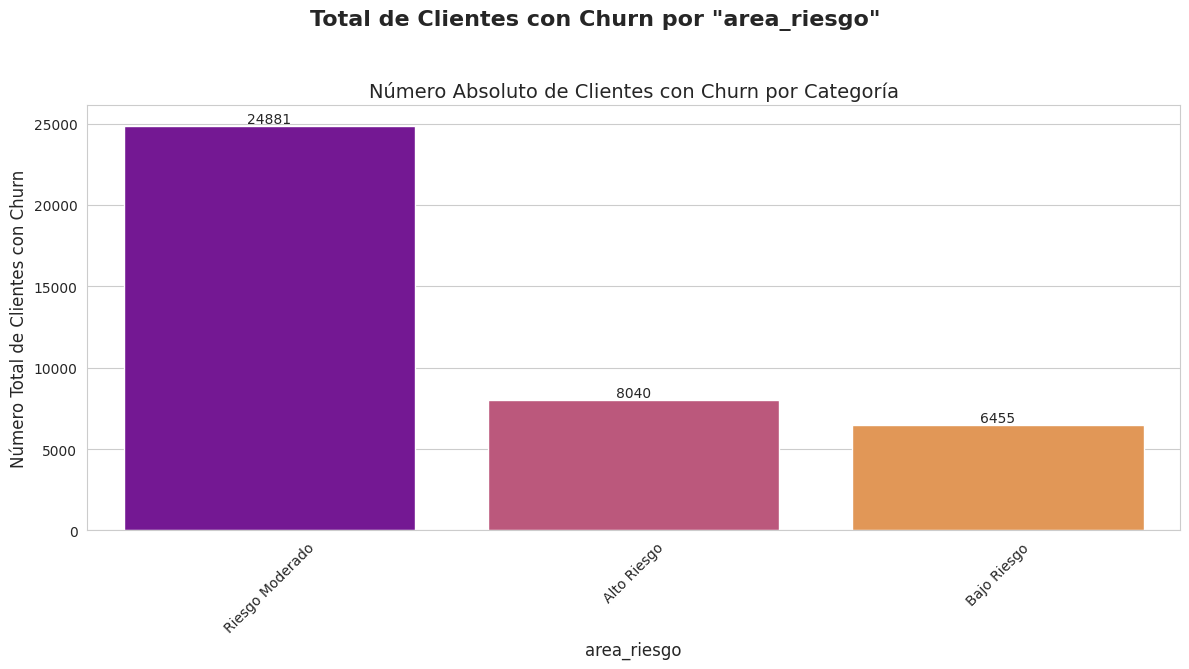

In [114]:
from utils import analizar_churn_categorica

df_train_agrupado_area, mapeo_area = agrupar_categoria_por_churn(
    df=df_train_no_data, 
    columna='area', 
    umbral_alto=0.515, 
    umbral_bajo=0.47,
    nombre_nueva_columna='area_riesgo'
)

print("--- Mapeo de áreas a grupos de riesgo ---")
print(mapeo_area)

print("\n--- Recuento de clientes en cada nuevo grupo de riesgo ---")
print(df_train_agrupado_area['area_riesgo'].value_counts())
analizar_churn_categorica(df_train_agrupado_area, 'area_riesgo')

## Ethnic

--- Análisis de Churn para la Variable Categórica: 'ethnic' ---
        Tasa de Churn  Total Clientes  Total Churn
ethnic                                            
N            0.489065           26475        12948
H            0.507047           10784         5468
S            0.490703           10218         5014
U            0.499426            8710         4350
G            0.492456            4772         2350
O            0.580616            3312         1923
I            0.505447            3029         1531
Z            0.402746            3496         1408
J            0.517730            2256         1168
F            0.497336            1689          840
UNKN         0.467523            1401          655
B            0.564982            1108          626
R            0.526634             826          435
D            0.527817             701          370
P            0.378788             396          150
C            0.312821             195           61
M            0.547

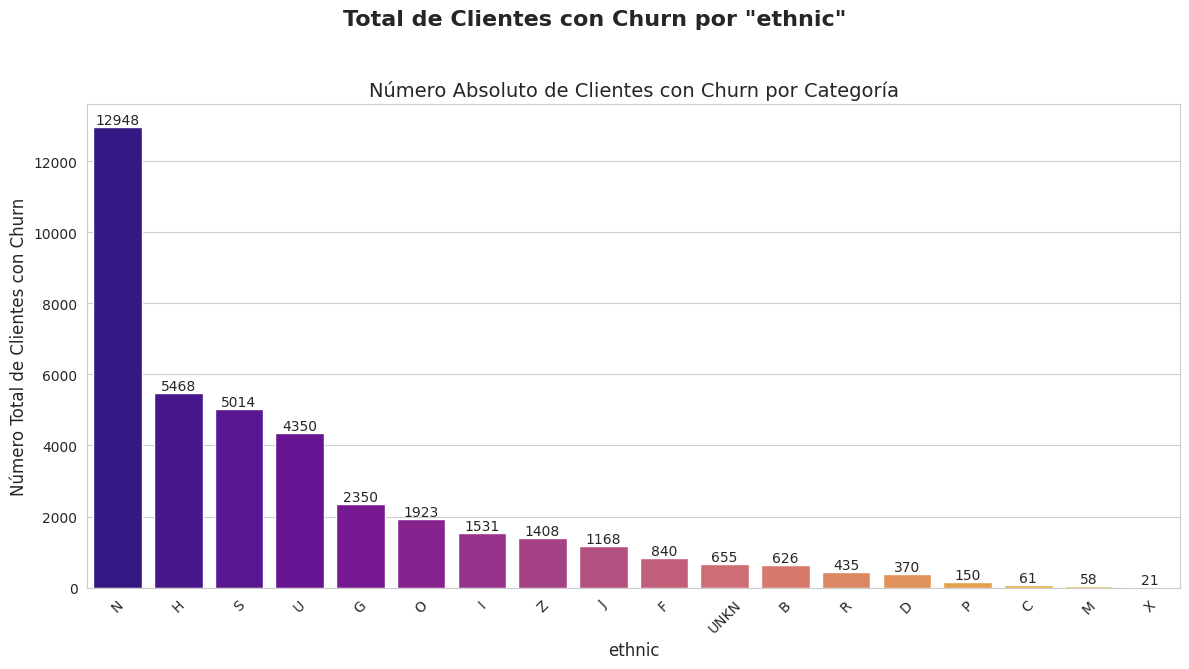

In [115]:
analizar_churn_categorica(df_train_agrupado_area, 'ethnic')

--- Mapeo de áreas a grupos de riesgo ---
ethnic
B           Alto Riesgo
C           Bajo Riesgo
D           Alto Riesgo
F       Riesgo Moderado
G       Riesgo Moderado
H       Riesgo Moderado
I       Riesgo Moderado
J           Alto Riesgo
M           Alto Riesgo
N       Riesgo Moderado
O           Alto Riesgo
P           Bajo Riesgo
R           Alto Riesgo
S       Riesgo Moderado
U       Riesgo Moderado
UNKN        Bajo Riesgo
X           Bajo Riesgo
Z           Bajo Riesgo
Name: ethnic_riesgo, dtype: object

--- Recuento de clientes en cada nuevo grupo de riesgo ---
ethnic_riesgo
Riesgo Moderado    65677
Alto Riesgo         8309
Bajo Riesgo         5551
Name: count, dtype: int64
--- Análisis de Churn para la Variable Categórica: 'ethnic_riesgo' ---
                 Tasa de Churn  Total Clientes  Total Churn
ethnic_riesgo                                              
Riesgo Moderado       0.494861           65677        32501
Alto Riesgo           0.551210            8309         458

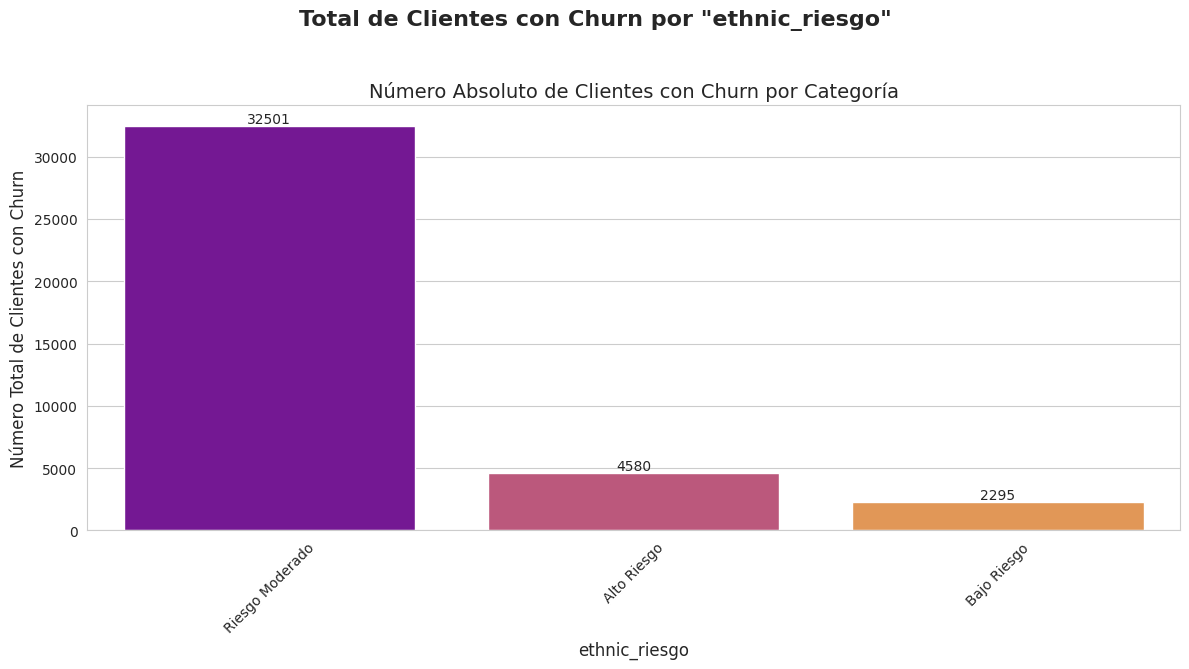

In [116]:
df_train_agrupado_ethnic, mapeo_ethnic = agrupar_categoria_por_churn(
    df=df_train_agrupado_area, 
    columna='ethnic', 
    umbral_alto=0.515, 
    umbral_bajo=0.47,
    nombre_nueva_columna='ethnic_riesgo'
)

print("--- Mapeo de áreas a grupos de riesgo ---")
print(mapeo_ethnic)

print("\n--- Recuento de clientes en cada nuevo grupo de riesgo ---")
print(df_train_agrupado_ethnic['ethnic_riesgo'].value_counts())
analizar_churn_categorica(df_train_agrupado_ethnic, 'ethnic_riesgo')

## crclscod

--- Análisis de Churn para la Variable Categórica: 'crclscod' ---
          Tasa de Churn  Total Clientes  Total Churn
crclscod                                            
AA             0.504591           29077        14672
A              0.516447           13498         6971
BA             0.522714           10126         5293
CA             0.467236            6669         3116
EA             0.405363            5072         2056
B              0.524144            3272         1715
ZA             0.499638            2764         1381
DA             0.448000            2875         1288
C              0.488312            1155          564
A2             0.623188             690          430
E4             0.291291             666          194
U              0.484456             386          187
GA             0.520548             219          114
G              0.550265             189          104
E              0.401544             259          104
I              0.502513          

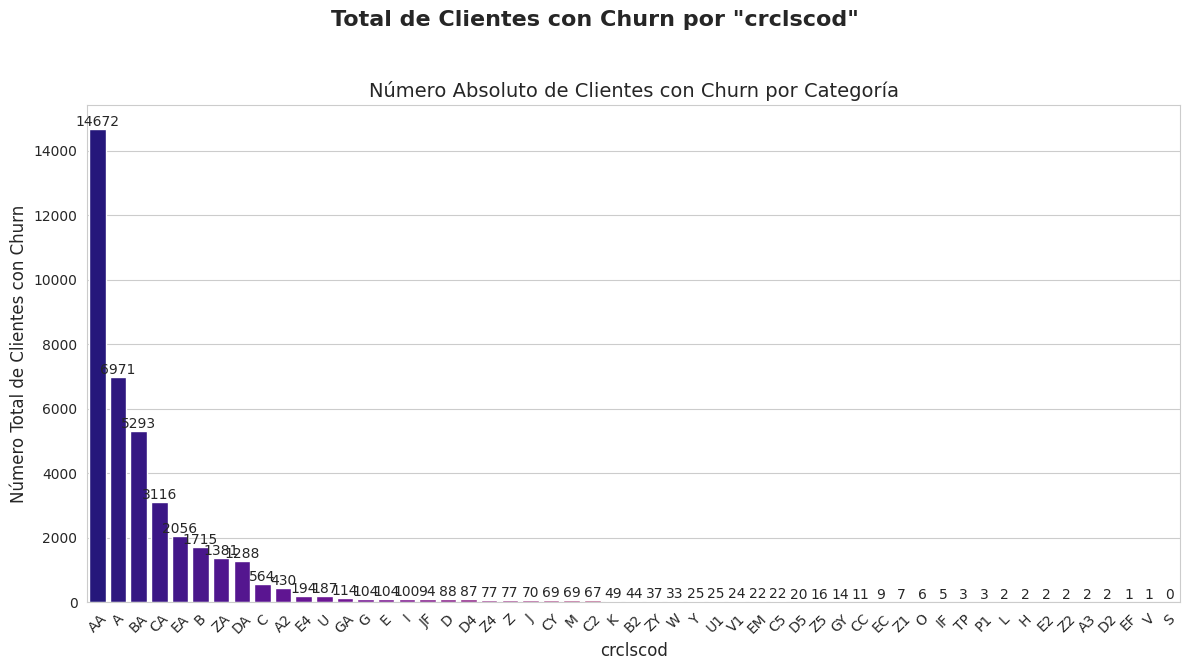

In [117]:
analizar_churn_categorica(df_train_agrupado_ethnic, 'crclscod')

--- Mapeo de áreas a grupos de riesgo ---
crclscod
A         Alto Riesgo
A2        Alto Riesgo
A3        Alto Riesgo
AA    Riesgo Moderado
B         Alto Riesgo
B2    Riesgo Moderado
BA        Alto Riesgo
C     Riesgo Moderado
C2        Bajo Riesgo
C5        Bajo Riesgo
CA        Bajo Riesgo
CC        Alto Riesgo
CY        Bajo Riesgo
D     Riesgo Moderado
D2        Alto Riesgo
D4        Bajo Riesgo
D5        Bajo Riesgo
DA        Bajo Riesgo
E         Bajo Riesgo
E2        Bajo Riesgo
E4        Bajo Riesgo
EA        Bajo Riesgo
EC        Bajo Riesgo
EF        Bajo Riesgo
EM        Alto Riesgo
G         Alto Riesgo
GA        Alto Riesgo
GY        Alto Riesgo
H         Bajo Riesgo
I     Riesgo Moderado
IF    Riesgo Moderado
J         Bajo Riesgo
JF        Alto Riesgo
K         Alto Riesgo
L         Bajo Riesgo
M     Riesgo Moderado
O         Bajo Riesgo
P1        Alto Riesgo
S         Bajo Riesgo
TP        Alto Riesgo
U     Riesgo Moderado
U1        Bajo Riesgo
V         Alto Riesgo
V1 

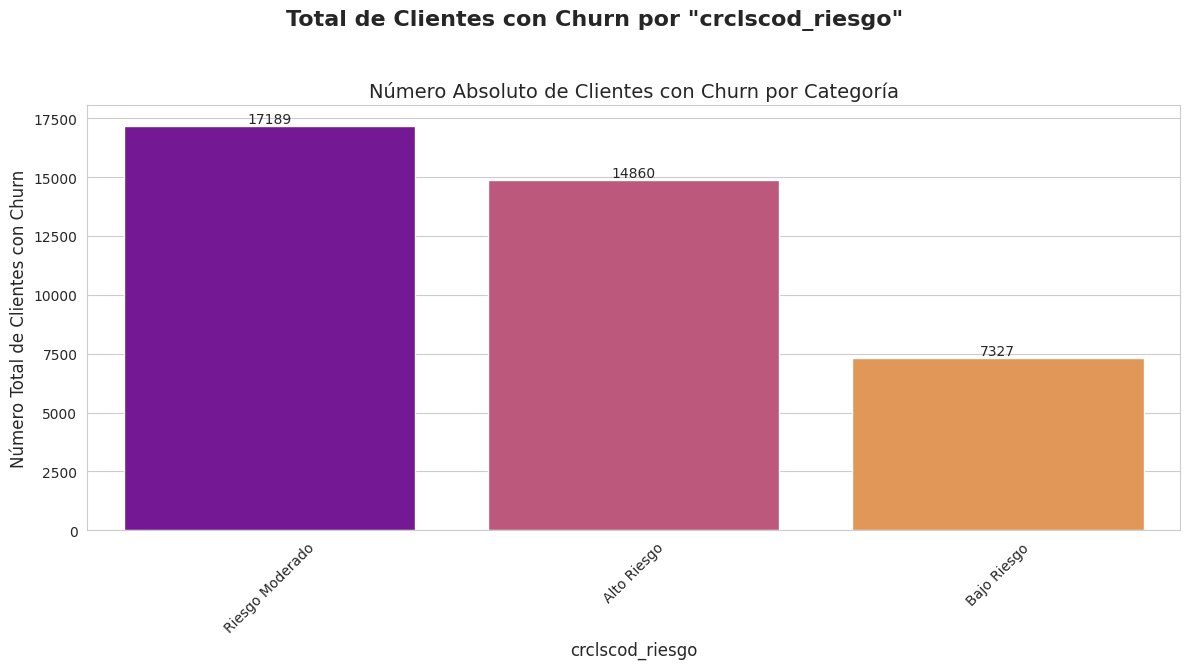

In [118]:
df_train_agrupado_crclscod, mapeo_crclscod = agrupar_categoria_por_churn(
    df=df_train_agrupado_area, 
    columna='crclscod', 
    umbral_alto=0.515, 
    umbral_bajo=0.47,
    nombre_nueva_columna='crclscod_riesgo'
)

print("--- Mapeo de áreas a grupos de riesgo ---")
print(mapeo_crclscod)

print("\n--- Recuento de clientes en cada nuevo grupo de riesgo ---")
print(df_train_agrupado_crclscod['crclscod_riesgo'].value_counts())
analizar_churn_categorica(df_train_agrupado_crclscod, 'crclscod_riesgo')

## Análisis de colinealidad de uso

In [119]:
df_train_agrupado = df_train_agrupado_crclscod

# Calcular la matriz de correlación solo para estas variables
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

variables_a_comparar = df_train_agrupado.select_dtypes(include=['number']).columns.tolist()

correlaciones = df_train_agrupado[variables_a_comparar].corr()

# Extraer la correlación de cada variable con 'churn'
correlacion_con_churn = correlaciones['churn'].sort_values(key=lambda x: abs(x), ascending=False)

print("Correlación de las variables con 'churn' (ordenada por fuerza):")
print(correlacion_con_churn)

umbral_correlacion = 0.02

# Obtener la lista de variables a descartar.
# Excluimos 'churn' ya que es la variable objetivo.
variables_a_descartar = correlacion_con_churn[
    (abs(correlacion_con_churn) < umbral_correlacion) & (correlacion_con_churn.index != 'churn')
].index.tolist()

df_train_seleccionado = df_train_agrupado.drop(columns=variables_a_descartar, axis=1)

# Opcional: imprimir las dimensiones del DataFrame para verificar el cambio
print(f"\nForma del DataFrame original: {df_train_agrupado.shape}")
print(f"Forma del DataFrame después de la selección: {df_train_seleccionado.shape}")

Correlación de las variables con 'churn' (ordenada por fuerza):
churn              1.000000
eqpdays            0.112963
hnd_price         -0.103631
totmrc_Mean       -0.067859
mou_Mean          -0.056196
complete_Mean     -0.050419
comp_vce_Mean     -0.050255
mou_cvce_Mean     -0.049897
avg3mou           -0.049102
mou_opkv_Mean     -0.047876
opk_vce_Mean      -0.047419
attempt_Mean      -0.046798
plcd_vce_Mean     -0.046569
peak_vce_Mean     -0.046542
mou_rvce_Mean     -0.045491
uniqsubs           0.044766
mou_peav_Mean     -0.044504
avg3qty           -0.043726
models            -0.043331
lor               -0.042423
avg6mou           -0.041098
recv_vce_Mean     -0.040992
owylis_vce_Mean   -0.040703
iwylis_vce_Mean   -0.040036
avg6qty           -0.038354
phones            -0.038317
ccrndmou_Mean     -0.038002
cc_mou_Mean       -0.035819
custcare_Mean     -0.034923
mouowylisv_Mean   -0.034223
inonemin_Mean     -0.034059
mouiwylisv_Mean   -0.033862
unan_vce_Mean     -0.033483
change_mou  

### One-hot encoding

In [120]:
categorical_cols = df_train_seleccionado.select_dtypes(include=['object', 'category']).columns.tolist()

df_train_codificado = pd.get_dummies(df_train_seleccionado, columns=categorical_cols, drop_first = True)
columnas_finales_train = df_train_codificado.columns.tolist()

len(columnas_finales_train)


177

## Todo el preprocesado de X_test

In [121]:
import sys
import os

# Obtiene la ruta al directorio padre (donde debería estar la carpeta 'churn_library')
# Ajusta el '..' si la estructura de tu carpeta es diferente
ruta_a_la_raiz_del_proyecto = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añade esta ruta al path de Python
sys.path.append(ruta_a_la_raiz_del_proyecto)

In [122]:
from churn_library.processing_helpers import (remove_rows_with_any_null,
                                              clean_negatives,
                                              create_null_flags,
                                              impute_with_constant)
import json

with open('../data/processed/imputation_values.json', 'r') as f:
    imputation_values_from_train = json.load(f)

with open('../airflow/config/churn_pipeline_config.json', 'r') as f:
    config = json.load(f)

df_test = pd.read_csv('../data/raw/test.csv', sep=';')

delete_if_null = config['preprocessing']['row_removal']['null_subset_cols']

#Remove rows with any null
df_test_nonulls = remove_rows_with_any_null(df_test, delete_if_null)
print(len(df_test_nonulls))

#Remove negatives
delete_if_negative = config['preprocessing']['negative_values']['exception_cols']
df_test_nonegatives = clean_negatives(df_test_nonulls, delete_if_negative)
print(len(df_test_nonegatives))

#Create null flags
columns_null_flag = config['preprocessing']['null_flags']['columns']
df_test_nullflag = create_null_flags(df_test_nonegatives, columns_null_flag)
print(len(df_test_nullflag.columns))




19926
- totmrc_Mean: 2 negative values
- eqpdays: 20 negative values
       totmrc_Mean  eqpdays
94         79.9900     -1.0
2051       -6.0500    119.0
4561       62.2825     -1.0
5084       74.9925     -2.0
5762       51.9800     -3.0
6131       42.1675     -4.0
8278       30.0000     -2.0
9772       44.9900     -1.0
10301      74.9900     -3.0
13040      44.9900     -3.0
14348      74.9900     -3.0
14488     152.4750     -3.0
15249      47.0075     -2.0
15981      44.8225     -1.0
16522      84.9900     -2.0
16549      34.9800     -4.0
16960      32.9900     -2.0
17445      -0.0825    369.0
17454      29.9900     -1.0
17997      41.2425     -1.0
18452      49.9900     -3.0
18612      59.9900     -1.0

--- Cleaning negative values (if applicable) ---
Original dataset length: 19926
Length after cleaning negatives: 19904
Deleted rows: 22
19904
101


/home/paloma/churn-estimation/churn_library/processing_helpers.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_problematic = df[mask_total_negatives]


In [123]:
#Impute medians from stored values

columns_impute_median = config['preprocessing']['imputation']['median_fill_columns']
for col in columns_impute_median:
    if col in imputation_values_from_train.keys():
        value = imputation_values_from_train[col]
        #df_test_nullflag[col] = df_test_nullflag.fillna({col: value})
        df_test_nullflag[col] = df_test_nullflag[col].fillna(value)



In [127]:
# Impute categoricals

fill_value = config['preprocessing']['imputation']['categorical_fill_value']
cols_for_unkn = df_test_nullflag.select_dtypes(include=['object', 'category']).columns.tolist()
# We use your helper function to impute
print(cols_for_unkn)
df_processed = impute_with_constant(df_test_nullflag, cols_for_unkn, fill_value=fill_value)

['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']
Imputed 21 columns with constant value: 'UNKN'


In [125]:
remaining_cols = ['rv', 'truck', 'forgntvl']

if col in remaining_cols:
    df_processed[col] = df_processed[col].fillna(fill_value)



In [126]:
# Check for null values in each column
nulls_per_column = df_processed.isnull().sum()

print("Recuento de valores nulos por columna:")
print(nulls_per_column)

Recuento de valores nulos por columna:
rev_Mean               0
mou_Mean               0
totmrc_Mean            0
da_Mean                0
ovrmou_Mean            0
ovrrev_Mean            0
vceovr_Mean            0
datovr_Mean            0
roam_Mean              0
change_mou             0
change_rev             0
drop_vce_Mean          0
drop_dat_Mean          0
blck_vce_Mean          0
blck_dat_Mean          0
unan_vce_Mean          0
unan_dat_Mean          0
plcd_vce_Mean          0
plcd_dat_Mean          0
recv_vce_Mean          0
recv_sms_Mean          0
comp_vce_Mean          0
comp_dat_Mean          0
custcare_Mean          0
ccrndmou_Mean          0
cc_mou_Mean            0
inonemin_Mean          0
threeway_Mean          0
mou_cvce_Mean          0
mou_cdat_Mean          0
mou_rvce_Mean          0
owylis_vce_Mean        0
mouowylisv_Mean        0
iwylis_vce_Mean        0
mouiwylisv_Mean        0
peak_vce_Mean          0
peak_dat_Mean          0
mou_peav_Mean          0
mou_pead_Me